In [ ]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

!pip uninstall h2o


!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
!pip install category_encoders

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 176.0 MB 6.6 kB/s 
  Created wheel for h2o: filename=h2o-3.36.0.2-py2.py3-none-any.whl size=176112127 sha256=05a2a9165a6868a7065b0d6b397f77ec009e6984cf6ce0e4a1cb7f889e1b0fc2
  Stored in directory: /root/.cache/pip/wheels/0b/83/bd/343a6140119b4098103e725e1cfe9f198568d13cf103acbc7c
Successfully built h2o
     |████████████████████████████████| 82 kB 371 kB/s 


**Abstract -**

The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be subscribed ('yes') or not ('no') subscribed.
AutoML algorithm is applied to train the model and get the best results.
Hyperparameter tuning is done to find the most important hypterparameters.

In [ ]:
import pandas as pd
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 
import scipy
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
url = files.upload()

Saving new_train.csv to new_train.csv


In [ ]:
import io
df1 = pd.read_csv(io.StringIO(url['new_train.csv'].decode('utf-8')))

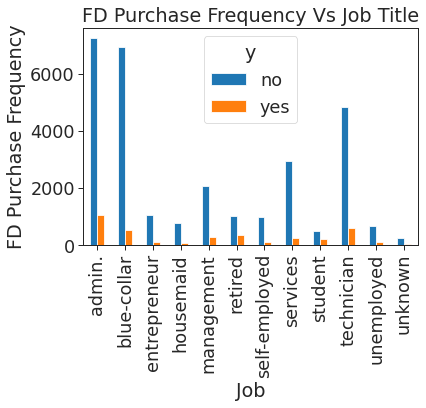

In [83]:
pd.crosstab(df1.job,df1.y).plot(kind='bar')
plt.title('FD Purchase Frequency Vs Job Title')
plt.xlabel('Job')
plt.ylabel('FD Purchase Frequency')
plt.show()

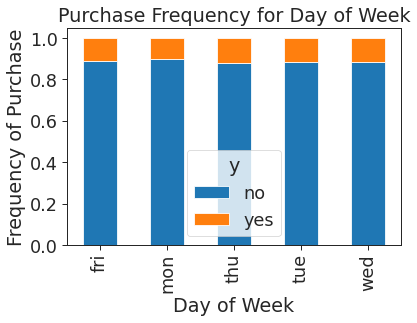

In [84]:
dow = pd.crosstab(df1.day_of_week,df1.y)
dow.div(dow.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.show()

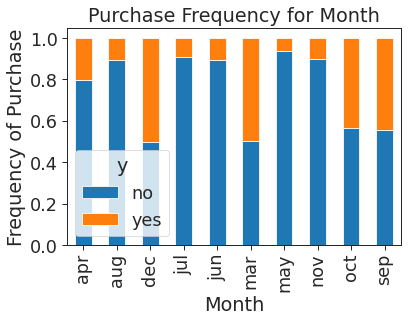

In [85]:
mon = pd.crosstab(df1.month,df1.y)
mon.div(mon.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.show()

In [ ]:
df1 = df1.dropna()
df1.drop(['campaign'], axis=1, inplace=True)
df1.drop(['marital'], axis=1, inplace=True)
df1.drop(['day_of_week'], axis=1, inplace=True)
df1.drop(['default'], axis=1, inplace=True)

df1 = df1.replace(to_replace = ['yes','no'],value = ['1','0'])

Job = pd.get_dummies(df1['job'])
Job.drop(['unknown'], axis=1, inplace=True)

Education = pd.get_dummies(df1['education'])
Education.drop(['unknown'], axis=1, inplace=True)

Contact = pd.get_dummies(df1['contact'], drop_first=True)

Month = pd.get_dummies(df1['month'], drop_first=True)

Poutcome = pd.get_dummies(df1['poutcome'], drop_first=True)

In [ ]:
df1 = pd.concat([df1, Job, Education, Contact, Month, Poutcome], axis=1)
df1.drop(['job', 'education', 'contact', 'month', 'poutcome'], axis=1, inplace=True)
df1['housing'] = df1['housing'].apply(pd.to_numeric,errors="coerce")
df1 = df1.fillna(0)
df1['housing'] = df1['housing'].astype(int)
df1['loan'] = df1['loan'].apply(pd.to_numeric,errors="coerce")
df1 = df1.fillna(0)
df1['loan'] = df1['loan'].astype(int)
df1['y'] = pd.to_numeric(df1['y'])

In [ ]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

In [ ]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [ ]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:21716 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpt6_k_uq5
  JVM stdout: /tmp/tmpt6_k_uq5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpt6_k_uq5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:21716
Connecting to H2O server at http://127.0.0.1:21716 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_l4s6tn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
df = h2o.H2OFrame(df1)
df.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


age,housing,loan,duration,pdays,previous,y,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,telephone,aug,dec,jul,jun,mar,may,nov,oct,sep,nonexistent,success
49,0,0,227,999,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
37,0,0,202,999,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
78,0,0,1148,999,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
36,1,0,120,999,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0
59,0,0,368,999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
29,0,0,256,999,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
26,0,0,449,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
30,1,0,126,999,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
50,0,0,574,999,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
33,1,0,498,999,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
# Create a 80/20 train/test splie
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

In [ ]:
print(df_train.shape)
print(df_test.shape)

(26459, 37)
(6491, 37)


In [ ]:
X=df.columns
print(X)

['age', 'housing', 'loan', 'duration', 'pdays', 'previous', 'y', 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'telephone', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'nonexistent', 'success']


In [ ]:
df.types

{'admin.': 'int',
 'age': 'int',
 'aug': 'int',
 'basic.4y': 'int',
 'basic.6y': 'int',
 'basic.9y': 'int',
 'blue-collar': 'int',
 'dec': 'int',
 'duration': 'int',
 'entrepreneur': 'int',
 'high.school': 'int',
 'housemaid': 'int',
 'housing': 'int',
 'illiterate': 'int',
 'jul': 'int',
 'jun': 'int',
 'loan': 'int',
 'management': 'int',
 'mar': 'int',
 'may': 'int',
 'nonexistent': 'int',
 'nov': 'int',
 'oct': 'int',
 'pdays': 'int',
 'previous': 'int',
 'professional.course': 'int',
 'retired': 'int',
 'self-employed': 'int',
 'sep': 'int',
 'services': 'int',
 'student': 'int',
 'success': 'int',
 'technician': 'int',
 'telephone': 'int',
 'unemployed': 'int',
 'university.degree': 'int',
 'y': 'int'}

In [ ]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [ ]:
y = 'y'
X.remove('y')

In [ ]:
aml.train(x=X,y=y,training_frame=df_train)  

AutoML progress: |
17:07:31.102: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

███
17:07:41.235: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

█
17:07:44.292: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

████
17:07:57.459: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical befo

In [ ]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_4_AutoML_1_20220213_170729,0.0616815,0.248358,0.0616815,0.126808,0.173715
StackedEnsemble_BestOfFamily_2_AutoML_1_20220213_170729,0.0619196,0.248836,0.0619196,0.128074,0.173931
StackedEnsemble_BestOfFamily_3_AutoML_1_20220213_170729,0.06192,0.248837,0.06192,0.126791,0.174033
StackedEnsemble_AllModels_3_AutoML_1_20220213_170729,0.0619671,0.248932,0.0619671,0.127108,0.174017
StackedEnsemble_AllModels_2_AutoML_1_20220213_170729,0.0619689,0.248936,0.0619689,0.126954,0.174065
StackedEnsemble_AllModels_1_AutoML_1_20220213_170729,0.0620457,0.24909,0.0620457,0.127921,0.174025
StackedEnsemble_BestOfFamily_1_AutoML_1_20220213_170729,0.0621998,0.249399,0.0621998,0.129464,0.174323
XGBoost_grid_1_AutoML_1_20220213_170729_model_15,0.0623101,0.24962,0.0623101,0.125499,0.175372
GBM_grid_1_AutoML_1_20220213_170729_model_9,0.0625776,0.250155,0.0625776,0.127947,0.174927
XGBoost_grid_1_AutoML_1_20220213_170729_model_28,0.0625826,0.250165,0.0625826,0.124672,0.17624


In [ ]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'GLM_1_AutoML_1_20220213_170729': 57,
 'StackedEnsemble_AllModels_1_AutoML_1_20220213_170729': 5,
 'StackedEnsemble_AllModels_2_AutoML_1_20220213_170729': 4,
 'StackedEnsemble_AllModels_3_AutoML_1_20220213_170729': 3,
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20220213_170729': 6,
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20220213_170729': 1,
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20220213_170729': 2,
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20220213_170729': 0,
 'XGBoost_grid_1_AutoML_1_20220213_170729_model_15': 7}

In [ ]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

7


In [ ]:
best_model.algo

'xgboost'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

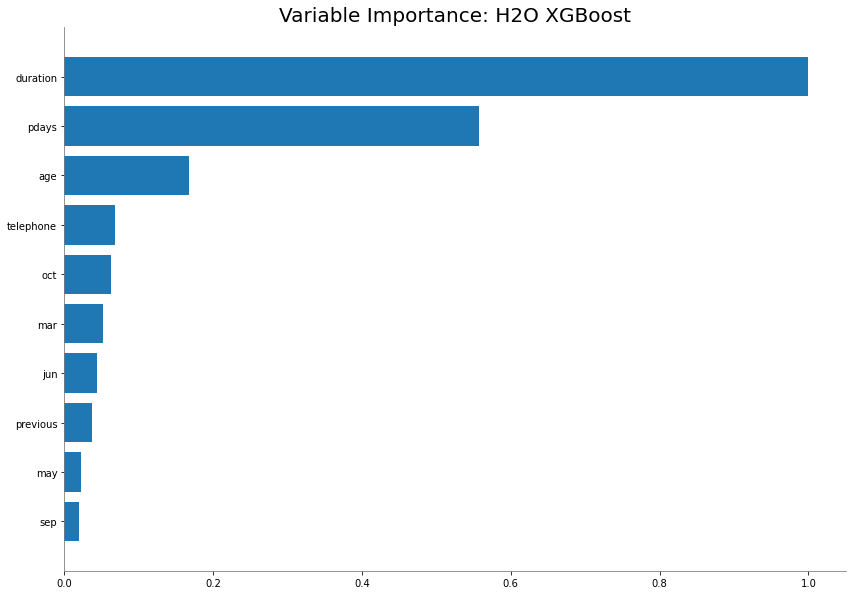

<Figure size 432x288 with 0 Axes>

In [ ]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

**Write 4 top variables**

Duration, pdays, success and age

57
glm


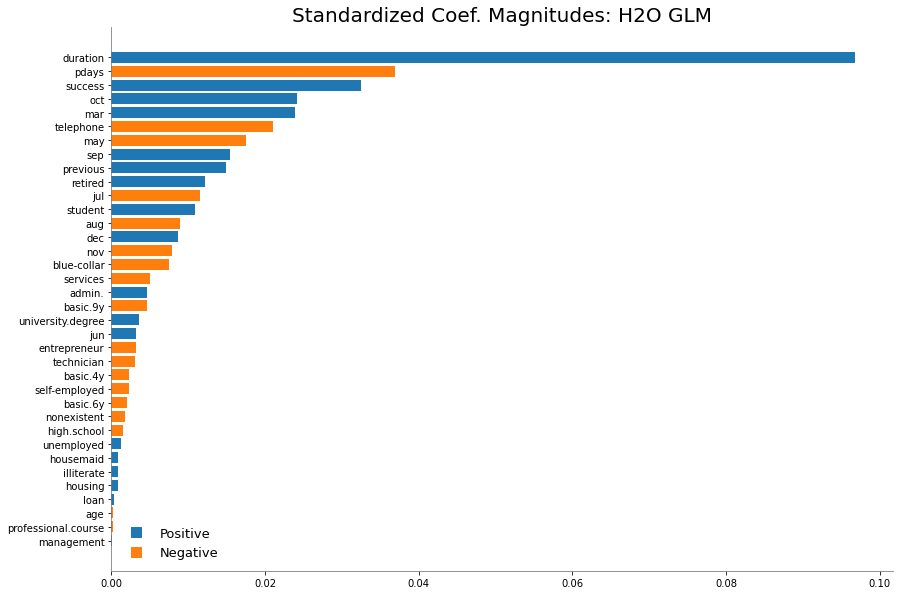

In [ ]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo) 
  glm_model.std_coef_plot()

In [ ]:
print(best_model.rmse(train = True))

0.23030320198712198


In [ ]:
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [ ]:
mod_perf=best_model.model_performance(df_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 0.06356921043766922,
 'null_degrees_of_freedom': None,
 'null_deviance': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'rmse': 0.2521293525904297}

In [ ]:
predictions = best_model.predict(df_test)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [ ]:
y_pred=h2o.as_list(predictions)
y_pred[0:5]

,predict
0,0.009512
1,0.112824
2,-0.007333
3,-0.000211
4,0.091537


In [ ]:
y_test=h2o.as_list(df_test[y])
y_test[0:5]

,y
0,0
1,0
2,0
3,0
4,0


PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_1_20220213_170729_model_15 on column 'duration'.


,duration,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.049276,0.143435,0.000790
1,258.842105,0.094296,0.169554,0.000934
2,517.684211,0.205150,0.183369,0.001010
3,776.526316,0.381528,0.151243,0.000833
4,1035.368421,0.595275,0.112624,0.000620
5,1294.210526,0.651411,0.096962,0.000534
6,1553.052632,0.685563,0.097049,0.000535
7,1811.894737,0.720233,0.094175,0.000519
8,2070.736842,0.629780,0.088191,0.000486
9,2329.578947,0.629780,0.088191,0.000486


[]

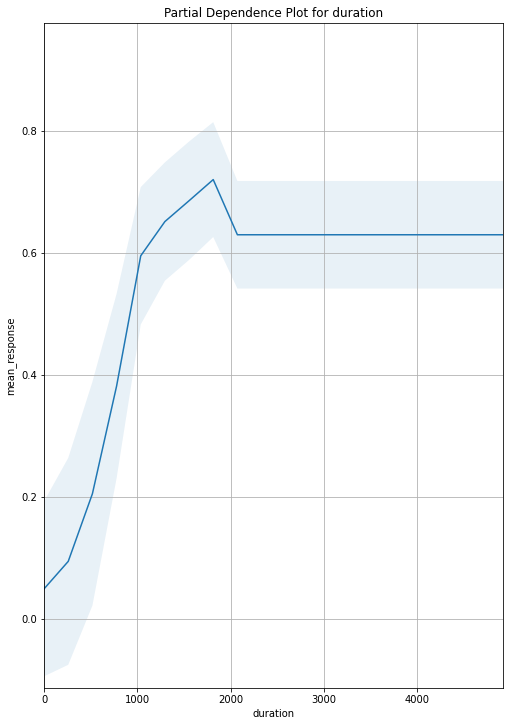

In [ ]:
best_model.partial_plot(df, cols=['duration'])

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_1_20220213_170729_model_15 on column 'age'.


,age,mean_response,stddev_response,std_error_mean_response
0,17.000000,0.258608,0.183417,0.001010
1,21.263158,0.258608,0.183417,0.001010
2,25.526316,0.136259,0.201436,0.001110
3,29.789474,0.116855,0.203457,0.001121
4,34.052632,0.112740,0.200701,0.001106
5,38.315789,0.103007,0.188278,0.001037
6,42.578947,0.100406,0.186383,0.001027
7,46.842105,0.099726,0.183848,0.001013
8,51.105263,0.107358,0.185132,0.001020
9,55.368421,0.103427,0.188616,0.001039



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_1_20220213_170729_model_15 on column 'telephone'.


,telephone,mean_response,stddev_response,std_error_mean_response
0,0.0,0.147012,0.208816,0.001150
1,1.0,0.094932,0.170304,0.000938



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_1_20220213_170729_model_15 on column 'duration'.


,duration,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.049276,0.143435,0.000790
1,258.842105,0.094296,0.169554,0.000934
2,517.684211,0.205150,0.183369,0.001010
3,776.526316,0.381528,0.151243,0.000833
4,1035.368421,0.595275,0.112624,0.000620
5,1294.210526,0.651411,0.096962,0.000534
6,1553.052632,0.685563,0.097049,0.000535
7,1811.894737,0.720233,0.094175,0.000519
8,2070.736842,0.629780,0.088191,0.000486
9,2329.578947,0.629780,0.088191,0.000486



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_1_20220213_170729_model_15 on column 'pdays'.


,pdays,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.454263,0.134196,0.000739
1,52.578947,0.462657,0.161496,0.000890
2,105.157895,0.462657,0.161496,0.000890
3,157.736842,0.462657,0.161496,0.000890
4,210.315789,0.462657,0.161496,0.000890
5,262.894737,0.462657,0.161496,0.000890
6,315.473684,0.462657,0.161496,0.000890
7,368.052632,0.462657,0.161496,0.000890
8,420.631579,0.462657,0.161496,0.000890
9,473.210526,0.462657,0.161496,0.000890



PartialDependence: Partial Dependence Plot of model XGBoost_grid_1_AutoML_1_20220213_170729_model_15 on column 'previous'.


,previous,mean_response,stddev_response,std_error_mean_response
0,0.0,0.114045,0.199881,0.001101
1,1.0,0.141799,0.192596,0.001061
2,2.0,0.142914,0.204161,0.001125
3,3.0,0.117730,0.207466,0.001143
4,4.0,0.109898,0.202688,0.001117
5,5.0,0.110752,0.203417,0.001121
6,6.0,0.110752,0.203417,0.001121
7,7.0,0.108087,0.203758,0.001122


[, , , , ]

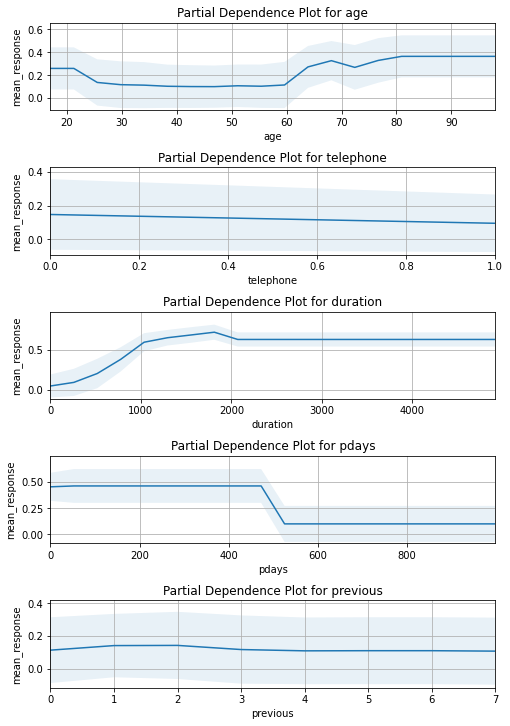

In [ ]:
best_model.partial_plot(df, cols=['age', 'telephone', 'duration', 'pdays', 'previous'])

**Is the relationship significant?**

Z_score == 0 it means all the predictors are on regression line it means the relationship is significant.

In [ ]:
def diagnostic_plots(df1, variable):
    
    plt.figure(figsize=(20, 9))

    plt.subplot(1, 3, 1)
    sns.histplot(data = df1, x=variable, bins=30, kde=True)
    plt.title('Histogram')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df1[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')
    
    plt.show()

In [ ]:
num_columns=df1[['duration','pdays','success','age', 'previous', 'telephone', 'mar', 'oct', 'nonexistent']].columns
num_columns

Index(['duration', 'pdays', 'success', 'age', 'previous', 'telephone', 'mar',
       'oct', 'nonexistent'],
      dtype='object')

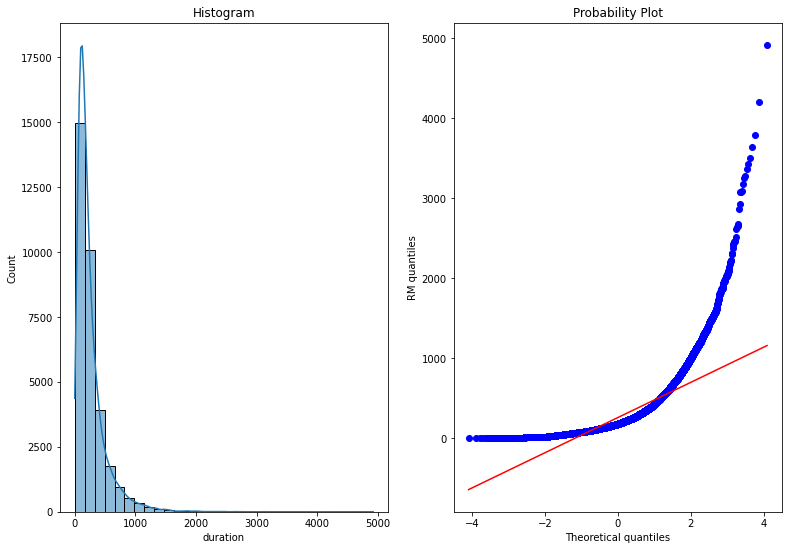

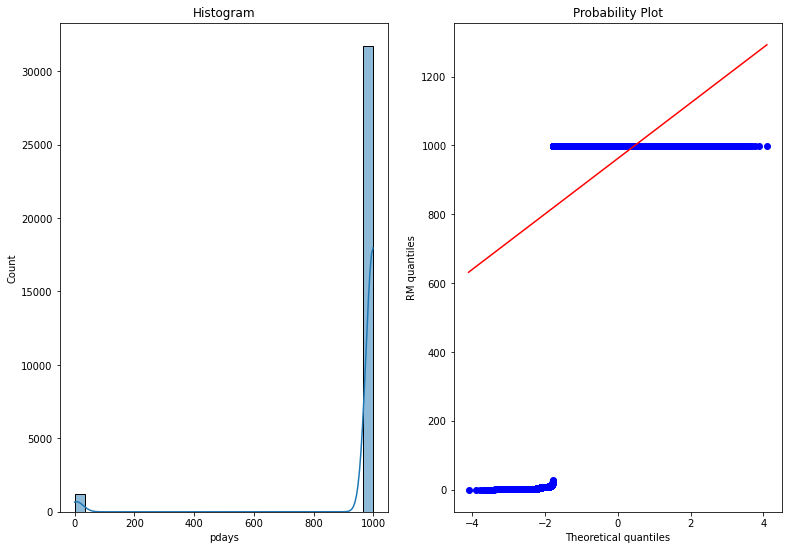

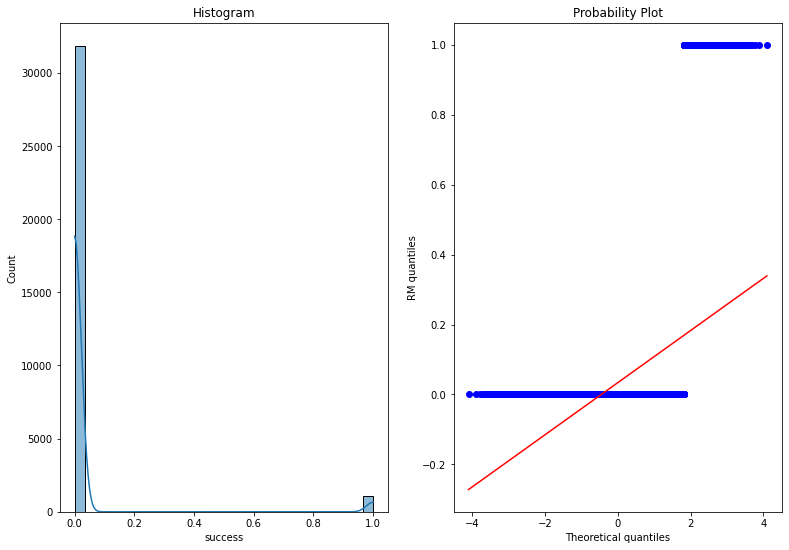

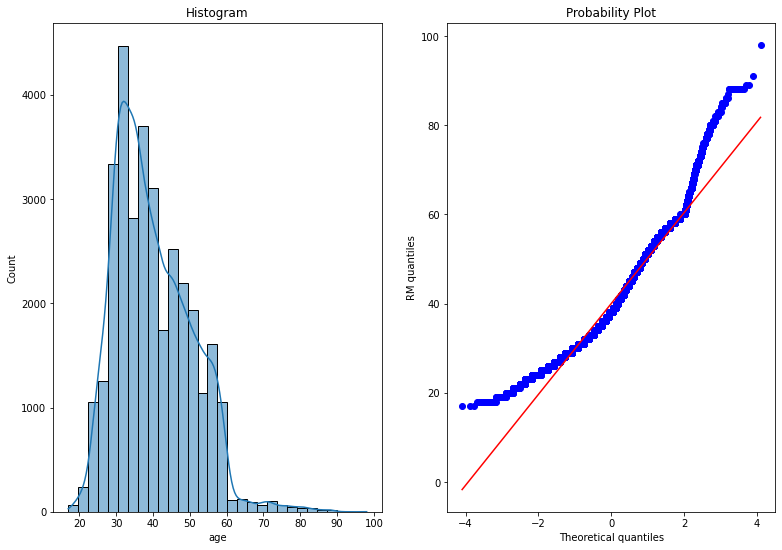

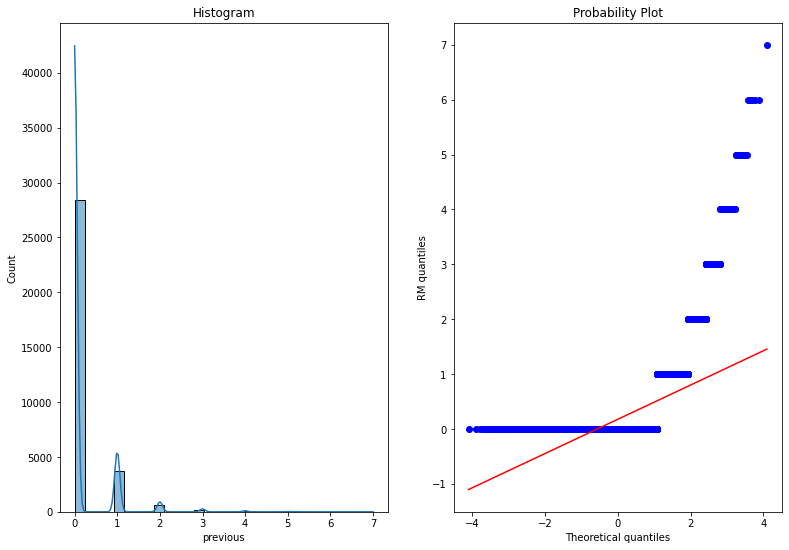

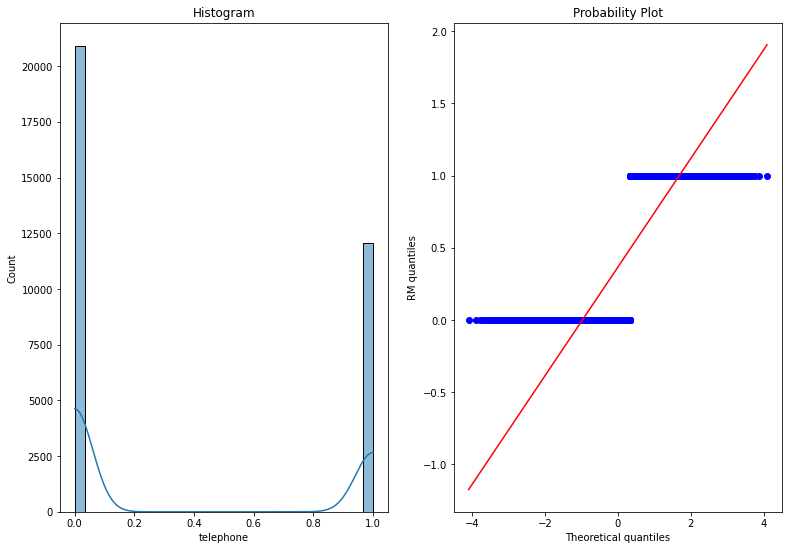

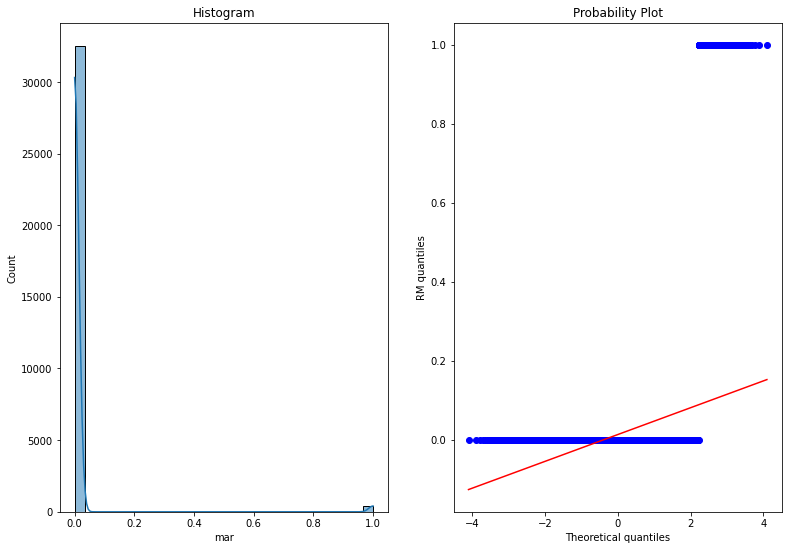

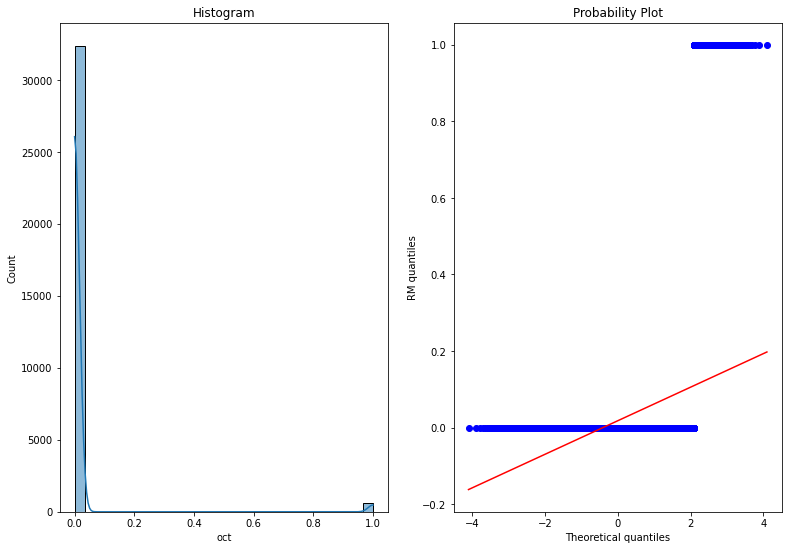

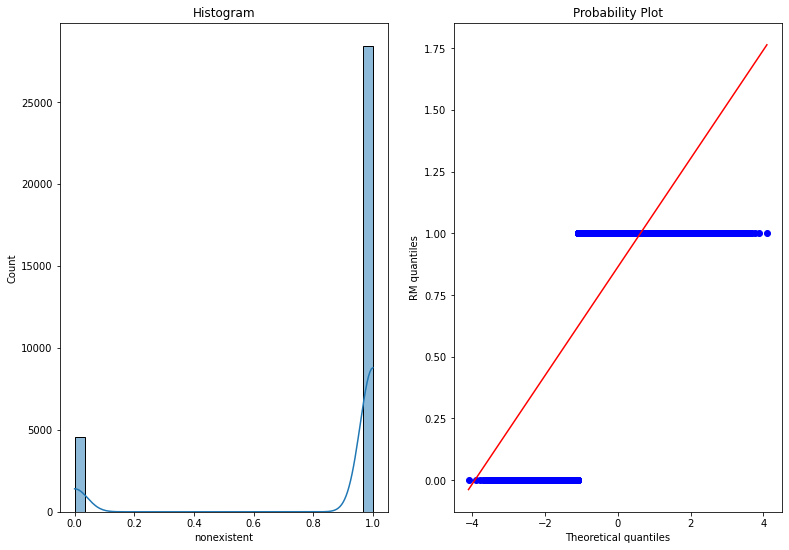

In [ ]:
for i in num_columns:
    diagnostic_plots(df1,i)

**Are any model assumptions violated?**

As none of the predictors are on line, all the model assumptions are violated.

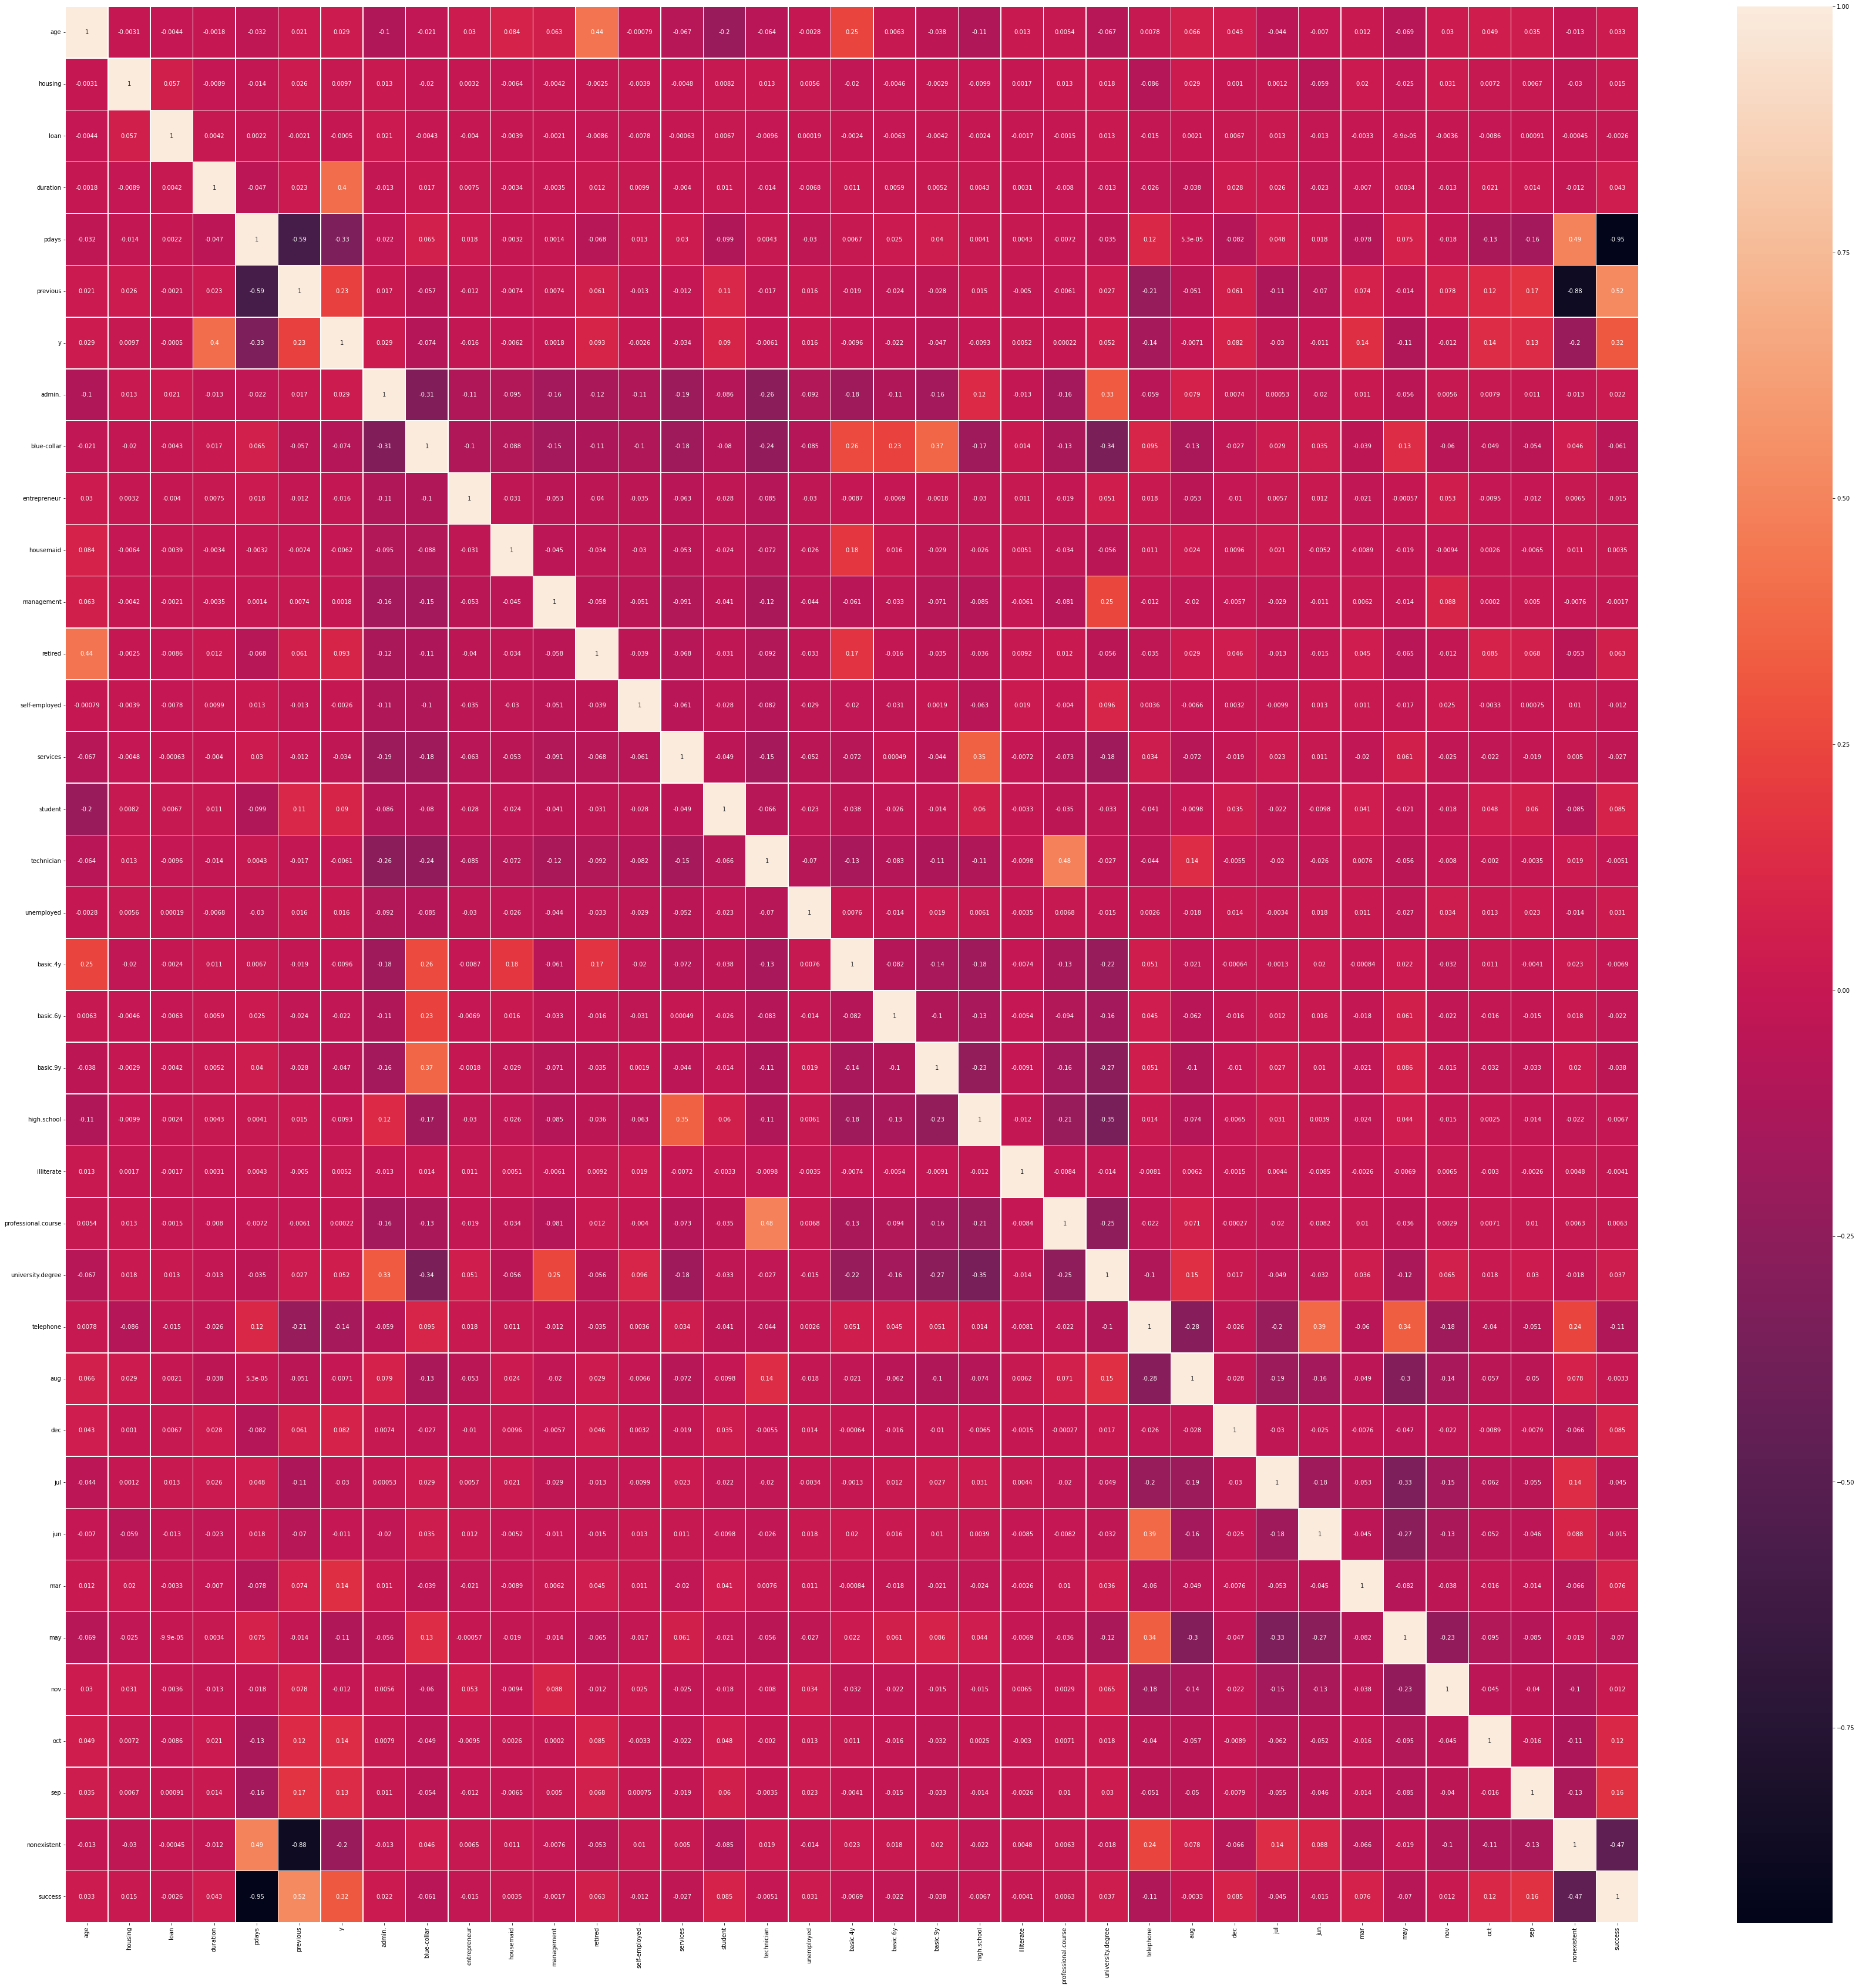

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(60,60))  
sns.heatmap(df1.corr(), annot=True, linewidths=.5, ax=ax)

**Is there any multicollinearity in the model?**

All the variables are correlated to itself only , hence it is not multicolinear.


In [69]:
Columns = df1[['duration', 'pdays', 'telephone', 'age']]

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = Columns.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(Columns.values, i)
                          for i in range(len(Columns.columns))]
  
print(vif_data)

     feature        VIF
0   duration   1.928621
1      pdays  10.704871
2  telephone   1.597834
3        age  10.135257


**In the multivariate models are predictor variables independent of all the other predictor variables?**
 
None of the variable is having same Variance Inflation Factor(VIF). Hence variables are independent of each other.

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model**

The following are the most significant predictor variables - 
Duration, pdays, telephone, age

In [74]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
X = df1.drop(['y'], axis=1)
y = df1['y']
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 0, test_size = 0.2)
model = XGBClassifier ( max_dept = 3, subsample = 1, n_estimators = 300, learning_rate = 0.050 )
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_predict = model.predict(X_test)
print('Train accuracy', accuracy_score(y_train, y_train_predict))
print('Test accuracy', accuracy_score(y_test, y_predict))

Train accuracy 0.9162367223065251
Test accuracy 0.9063732928679817


**Explain how you are preventing overfitting?**

As testing and training data accuracy is close to each other. Hence there is no overfitting in the data. 

**Which hyperparameters are important?**

The following hypterparameters are important (Model = XGBClassifier):

max_dept = 3, subsample = 1, n_estimators = 300, learning_rate = 0.050

**Does the model make sense?**

Yes, It makes sense but it can be improved as the R^2 value is low.

In [75]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
gbm = GradientBoostingClassifier()
mse = cross_val_score(gbm,X,y,scoring= 'neg_mean_squared_error',cv=5)
mean_mse = np.mean(mse)
print(mean_mse)

-0.09025796661608497


In [76]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor = GridSearchCV(ridge,parameters,scoring= 'neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 20}
-0.06951663050235445


**Does regularization help?**

The RMSE calculated by Ridge is lesser than the RMSE calculated by the AutoML algorithm (0.06 < 0.2156285069896893 (RMSE)). Hence regularization is not needed.

**Which independent variables are significant?**

The following are the independent variables - 

Duration, pdays, telephone, age

As there VIF is different.

In [77]:
import scipy.stats as stats

df1['duration_Zscore'] = stats.zscore(df1['duration'])
df1['pdays_Zscore'] = stats.zscore(df1['pdays'])
df1['telephone_Zscore'] = stats.zscore(df1['telephone'])
df1['age_Zscore'] = stats.zscore(df1['age'])
print(df1.head())


z_tdc = df1[['duration_Zscore']].mean()
z_tdm = df1[['pdays_Zscore']].mean()
z_tem = df1[['telephone_Zscore']].mean()
z_csc = df1[['age_Zscore']].mean()
print(round(z_tdc,4))
print(round(z_tdm,4))
print(round(z_tem,4))
print(round(z_csc,4))

   age  housing  loan  ...  pdays_Zscore  telephone_Zscore  age_Zscore
0   49        0     0  ...      0.196584         -0.758915    0.863739
1   37        0     0  ...      0.196584          1.317671   -0.289722
2   78        0     0  ...      0.196584         -0.758915    3.651268
3   36        1     0  ...      0.196584          1.317671   -0.385843
4   59        0     0  ...      0.196584         -0.758915    1.824956

[5 rows x 41 columns]
duration_Zscore   -0.0
dtype: float64
pdays_Zscore   -0.0
dtype: float64
telephone_Zscore   -0.0
dtype: float64
age_Zscore    0.0
dtype: float64


**Is the relationship significant?**

Z_score == 0 it means all the predictors are on regression line it means the relationship is significant.

**Coding professionalism?**


https://www.geeksforgeeks.org/hyperparameter-tuning/

https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/




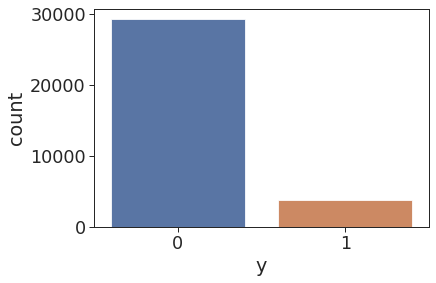

In [79]:
sns.set_context('paper', font_scale = 2) 
sns.set_style('ticks') 
sns.countplot(x ='y', data = df1, palette ='deep') 

**Conclusion -**

There are very less number of people who subscribed for long term deposits. The best model algorithm is 'XGBOOST'. There is no overfitting in the data as the testing data accuracy is close to training data accuracy. The model accuracy can be improved as the R^2 value is less. 

**Did I explain my licensing clearly?** 

MIT License

Copyright (c) 2022 soni-shr

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.